In [1]:
import sys
sys.path.insert(0, '../')

import transformers
import torch.nn as nn
from transformers import AlbertModel, AlbertConfig
import torch
import argparse
import os
from torch.utils.data import DataLoader, ConcatDataset, Subset
import pyxis.torch as pxt
from tqdm import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from consonant.model.tokenization import NGRAMTokenizer
from consonant.model.modeling import Consonant


In [18]:
def load_tokenizer_model(ckpt):
    state = torch.load(ckpt, map_location=torch.device('cpu'))
    tokenizer = NGRAMTokenizer(state['ngram'])

    config = AlbertConfig(**state['config_dict'])
    model = Consonant(config)
    model.load_state_dict(state['model_state_dict'])

    step = int(ckpt.split('-')[-1].split('.')[0])

    return tokenizer, model, state['ngram'], step


def get_dataloader(ngram, batch_size, num_workers):        
    dataset_dir = f'../dataset/processed/comments_{ngram}_100'
    data_dir = os.path.join(dataset_dir, 'val') 
    subset_list = [subset_dir for subset_dir in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, subset_dir))]
    val_dataset = ConcatDataset([pxt.TorchDataset(os.path.join(data_dir, subset_dir)) for subset_dir in subset_list])
    val_dataset = Subset(val_dataset, indices=list(range(0, len(val_dataset), 10) ))

    data_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=False
    )
    return data_loader


In [22]:
def evaluate(model, val_dataloader):
    list_length = list()
    list_acc = list()

    with torch.no_grad():
        for i, batch in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
            input_ids = batch['head_ids'].type(torch.LongTensor).cuda()
            answer_label = batch['midtail_ids'].type(torch.LongTensor).cuda()  
            attention_mask = batch['attention_masks'].type(torch.LongTensor).cuda()  
            
            answer_label[answer_label==0]=-100

            #print(input_ids.shape, attention_mask.shape,  answer_label.shape)
            output = model(input_ids, attention_mask=attention_mask, token_type_ids=None, answer_label=answer_label)
            logits = output[1]
            labels_hat = torch.argmax(logits, dim=2)
            correct = torch.sum(answer_label == labels_hat, dim=1).detach().cpu().numpy() 
            length = torch.sum(answer_label != -100, dim=1).detach().cpu().numpy() 

            acc = correct / length
            list_length.append(length)
            list_acc.append(acc)

            
    list_length = np.concatenate(list_length)
    list_acc = np.nan_to_num(np.concatenate(list_acc))
    return list_length, list_acc


In [25]:
def evaluate_model(model_size, batch_size, num_workers):

    ckpt_dir = f'../artifact/{model_size}'
    ckpts = sorted([ os.path.join(ckpt_dir, ckpt) for ckpt in os.listdir(ckpt_dir)])

    print("start ", model_size)
    list_metric = list()
    for ckpt in ckpts:
        tokenizer, model, ngram, step = load_tokenizer_model(ckpt)
        val_dataloader = get_dataloader(ngram, batch_size, num_workers)

        model.eval()
        model.cuda()

        list_length, list_acc = evaluate(model, val_dataloader)
        list_metric.append({'acc':list_acc.mean(), 'model':model_size, 'step': step})
        df = pd.DataFrame(list_metric)
        df.to_csv(f'{model_size}.csv', index=False)
        print(step, list_acc.mean())

    return list_metric


In [26]:

model_size = 'small'
batch_size = 4000
num_workers = 8
metric = evaluate_model(model_size, batch_size, num_workers)
df = pd.DataFrame(metric)
df.to_csv(f'{model_size}.csv', index=False)


start  small
100%|██████████| 124/124 [03:02<00:00,  1.48s/it]10000 0.5339132562491407

100%|██████████| 124/124 [03:03<00:00,  1.48s/it]
20000 0.5642143735336002
100%|██████████| 124/124 [03:05<00:00,  1.49s/it]30000 0.5720196145222469

100%|██████████| 124/124 [03:03<00:00,  1.48s/it]
40000 0.5773834655519946
100%|██████████| 124/124 [03:03<00:00,  1.48s/it]50000 0.5800127159491517

100%|██████████| 124/124 [03:03<00:00,  1.48s/it]60000 0.5830707625457898

100%|██████████| 124/124 [03:04<00:00,  1.48s/it]70000 0.5849325807845142

100%|██████████| 124/124 [03:05<00:00,  1.49s/it]
80000 0.586763176413494
100%|██████████| 124/124 [03:05<00:00,  1.50s/it]
90000 0.5880536718599931
100%|██████████| 124/124 [03:03<00:00,  1.48s/it]
100000 0.58910873589412
100%|██████████| 124/124 [03:03<00:00,  1.48s/it]
110000 0.5907436737546937
100%|██████████| 124/124 [03:03<00:00,  1.48s/it]120000 0.5911917246702255

100%|██████████| 124/124 [03:11<00:00,  1.54s/it]130000 0.5920516651829374

100%|██████

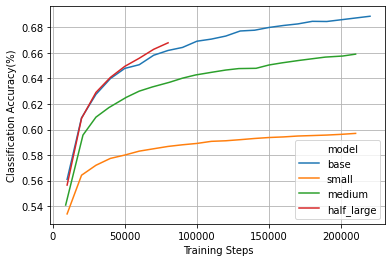

In [3]:
df = pd.read_csv('all_models.csv')
sns.lineplot(x="step", y="acc",
             hue="model", markers=True,
             data=df, dashes=True)
plt.grid()
plt.ylabel("Classification Accuracy(%)")
plt.xlabel("Training Steps")
plt.savefig('result.pdf')